In [ ]:
import Pkg
Pkg.add("PrettyTables")

In [1]:
using DataFrames, FredData, XLSX, SHA, Dates, CSV, TimeSeries, StatsBase, HiddenMarkovModels, Distributions, Plots, PrettyTables

In [3]:
function guess_init(n_scenarios)
    regimes_probs = rand(1:100,n_scenarios)
    return regimes_probs/sum(regimes_probs)
end

function guess_tmatrix(n_scenarios)
    regimes_probs = rand(1:100,n_scenarios,n_scenarios)
    return regimes_probs ./ sum(regimes_probs,dims=2)
end

function guess_distribution()
    sigma = rand(Uniform(0,0.25))
    means = rand(Uniform(-0.25,0.25))
    return Normal(means,sigma)
end

function train_hmm(data, n_scenarios = 2)

    function guess_distribution()
        sigma = rand(Uniform(0,0.25))
        means = rand(Uniform(-0.25,0.25))
        return Normal(means,sigma)
    end
    
    init_guess = guess_init(n_scenarios)
    guess_matrix = guess_tmatrix(n_scenarios)
    guess_dist = [guess_distribution() for s in 1:n_scenarios]
    hmm_guess = HMM(init_guess, guess_matrix, guess_dist);
    return hmm_est, loglikelihood_evolution = baum_welch(hmm_guess, data);
end 

train_hmm (generic function with 2 methods)

In [4]:
function regime_summary(loglikehood,hmm_est, freq = 1)
        tm = transition_matrix(hmm_est)
        
   return DataFrame(Dict(
      "mu1" => mean(obs_distributions(hmm_est)[1]) * freq,
      "sig1" => std(obs_distributions(hmm_est)[1]) *  freq^0.5,
      "mu2" => mean(obs_distributions(hmm_est)[2]) * freq,
      "sig2" => std(obs_distributions(hmm_est)[2]) * freq^0.5,       
      "p11" =>  tm[1,1],
      "p21" =>  tm[2,1],
      "loglikehood" => last(loglikehood),
      "prob1" =>  tm[2,1]/(tm[1,2]+tm[2,1])
      
  )) 
  end

regime_summary (generic function with 2 methods)

In [5]:
function regime_summary_2(loglikehood,hmm_est, freq = 1)
    tm = transition_matrix(hmm_est),
    n_regimes = length(initialization(hmm_est))
    dict = Dict()
   
    return n_regimes
      
end


regime_summary_2 (generic function with 2 methods)

In [6]:
source_data = TimeArray(CSV.File("assets_data_03.24.csv", delim=';', dateformat=Dict("Date" => "dd.mm.yyyy"), decimal=','),timestamp=:Date)
returns = percentchange(source_data, :log)

615×8 TimeArray{Union{Missing, Float64}, 2, Date, Matrix{Union{Missing, Float64}}} 1973-01-31 to 2024-03-31
┌────────────┬────────────┬─────────────┬──────────────┬──────────────┬─────────
│            │ ACWI_Net   │ USDPLN      │ ACWI_Net_PLN │ CPI_USA      │ CPI_PL ⋯
├────────────┼────────────┼─────────────┼──────────────┼──────────────┼─────────
│ 1973-01-31 │    missing │     missing │      missing │   0.00235067 │     mi ⋯
│ 1973-02-28 │    missing │     missing │      missing │   0.00701905 │     mi ⋯
│ 1973-03-31 │    missing │     missing │      missing │   0.00927727 │     mi ⋯
│ 1973-04-30 │    missing │     missing │      missing │   0.00690598 │     mi ⋯
│ 1973-05-31 │    missing │     missing │      missing │   0.00685862 │     mi ⋯
│ 1973-06-30 │    missing │     missing │      missing │    0.0068119 │     mi ⋯
│ 1973-07-31 │    missing │     missing │      missing │   0.00225501 │     mi ⋯
│ 1973-08-31 │    missing │     missing │      missing │    0.0179014 │     mi ⋯
│

In [7]:
stats = summarystats.(eachcol(values(returns)))

stats = DataFrame([stats[1],stats[2],stats[3]])


Row,mean,sd,min,q25,median,q75,max,nobs,nmiss
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64
1,0.00622469,0.0443616,-0.220834,-0.0181497,0.0124942,0.0330787,0.116238,615,180
2,0.000397277,0.0371301,-0.094026,-0.0247304,-0.00190905,0.0234364,0.166496,615,300
3,0.00581535,0.0380711,-0.111985,-0.0159863,0.00790446,0.0323534,0.105947,615,300


In [9]:
acwi_long = identity.(values(from(returns[:ACWI_Net,],Date(1988,01,01))))
hmm_est, loglikehood = train_hmm(acwi_long,2)
println("ACWI long 2")
regime_summary(loglikehood,hmm_est,12)

ACWI long 2


Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,774.685,-0.0115799,0.160692,0.94196,0.0597904,0.507429,0.195715,0.0873575


In [10]:
hmm_est, loglikehood = train_hmm(acwi_long,4)
println("ACWI long 4")
regime_summary(loglikehood,hmm_est,12)

ACWI long 4


Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,795.791,-0.455771,-0.294671,0.722673,0.229254,1.0,0.195794,0.0725377


In [11]:
acwi_98 = identity.(values(from(returns[:ACWI_Net],Date(1998,01,01))))
hmm_est, loglikehood = train_hmm(acwi_98,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,550.318,-0.0300665,0.173382,0.943248,0.0674221,0.542964,0.202369,0.0833695


In [12]:
acwi_03 = identity.(values(from(returns[:ACWI_Net],Date(2003,01,01))))
hmm_est, loglikehood = train_hmm(acwi_03,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,459.165,-0.0133202,0.168608,0.919349,0.0622193,0.435494,0.210608,0.0812767


In [49]:
acwi_pln_98 = identity.(values(from(returns[:ACWI_Net_PLN],Date(1998,01,01))))
println("mean $(mean(acwi_pln_98)*12), std: $(std(acwi_pln_98)*12^0.5)")
hmm_est_98_PLN, loglikehood = train_hmm(acwi_pln_98,2)
regime_summary(loglikehood,hmm_est_98_PLN,1)

mean 0.06978414756872021, std: 0.13188218245803085


Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,603.335,0.0134082,-0.0133853,0.950332,0.124522,0.714862,0.0276528,0.0514806


In [14]:
acwi_pln_01 = identity.(values(from(returns[:ACWI_Net_PLN],Date(2001,01,01))))
hmm_est, loglikehood = train_hmm(acwi_pln_01,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,543.406,0.143818,-0.149778,0.958618,0.115486,0.736197,0.091143,0.180197


In [15]:
acwi_pln_03 = identity.(values(from(returns[:ACWI_Net_PLN],Date(2003,01,01))))
hmm_est, loglikehood = train_hmm(acwi_pln_03,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,508.416,-0.0951999,0.143986,0.837693,0.0450782,0.217365,0.17823,0.0905752


In [26]:
usdpln_03 = identity.(values(from(returns[:USDPLN ],Date(2003,01,01))))
hmm_est, loglikehood = train_hmm(usdpln_03,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,484.829,-0.0247207,0.117703,0.992613,0.0316917,0.810976,0.106832,0.210462


In [27]:
function guess_init(n_scenarios)
    regimes_probs = rand(1:100,n_scenarios)
    return regimes_probs/sum(regimes_probs)
end

function guess_tmatrix(n_scenarios)
    regimes_probs = rand(1:100,n_scenarios,n_scenarios)
    return regimes_probs ./ sum(regimes_probs,dims=2)
end

function guess_distribution()
    corr = Matrix(1.0I,2,2)
    sigma = [rand(Uniform(0,0.25)),rand(Uniform(0,0.035))]
    means = [rand(Uniform(-0.5,0.5)),rand(Uniform(-0.01,0.12))]
    cov = cor2cov(corr,sigma)
    return MvNormal(means,cov)
end

using LinearAlgebra

In [168]:
acwi_and_pln = identity.(values(from(returns[:ACWI_Net_PLN, :USDPLN],Date(2001,01,01))))
n_scenarios = 2


init_guess = guess_init(n_scenarios)
guess_matrix = guess_tmatrix(n_scenarios)
guess_dist = [guess_distribution() for s in 1:n_scenarios]
hmm_guess = HMM(init_guess, guess_matrix, guess_dist);
println(hmm_guess)
hmm_est_concat, _ = baum_welch(hmm_guess, eachrow(acwi_and_pln));

Hidden Markov Model with:
 - initialization: [0.4935897435897436, 0.5064102564102564]
 - transition matrix: [0.4788732394366197 0.5211267605633803; 0.8043478260869565 0.1956521739130435]
 - observation distributions: [FullNormal(
dim: 2
μ: [-0.2509623807471162, 0.014707559122679926]
Σ: [0.0026401042688278557 0.0; 0.0 9.25680161421722e-5]
)
, FullNormal(
dim: 2
μ: [0.2796216174765179, 0.10285604942466454]
Σ: [0.016106113526144418 0.0; 0.0 1.8232579861409186e-6]
)
]


In [169]:
dist1 = obs_distributions(hmm_est_concat)[1]
dist2 = obs_distributions(hmm_est_concat)[2]

mean1 = mean(dist1) .* 12
mean2 = mean(dist2) .* 12

std1 = sqrt.(var(dist1)) .* 12^0.5
std2 = sqrt.(var(dist2)) .* 12^0.5
display("means")
display([mean1 mean2])
display("std")
display([std1 std2])
display("corr")
cor1 = cor(dist1)
display(cor1)
cor2 = cor(dist2)
display(cor2)


"means"

2×2 Matrix{Float64}:
  0.056319   0.453701
 -0.0147173  1.32579

"std"

2×2 Matrix{Float64}:
 0.128823  0.0942876
 0.125084  0.0283679

"corr"

2×2 Matrix{Float64}:
 1.0     0.2196
 0.2196  1.0

2×2 Matrix{Float64}:
  1.0       -0.947556
 -0.947556   1.0

In [170]:
acwi_short = identity.(values(from(returns[:ACWI_Net],Date(2001,01,01))))
hmm_est, loglikehood = train_hmm(acwi_short,2)
obs_distributions(hmm_est)

2-element Vector{Normal{Float64}}:
 Normal{Float64}(μ=0.013891940154582502, σ=0.02342090409705692)
 Normal{Float64}(μ=-0.0031354040057774584, σ=0.059348571985435514)

In [171]:
acwi_short = identity.(from(returns[:ACWI_Net],Date(2001,01,01)))
hmm_est, loglikehood = train_hmm(values(acwi_short),2)
HMM(initialization(hmm_est), transition_matrix(hmm_est), obs_distributions(hmm_est))
states,_ = viterbi(hmm_est,values(acwi_short))
states = Float64.(states)

279-element Vector{Float64}:
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 ⋮
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0

In [172]:
acwi_states = merge(acwi_short,identity.(from((returns[:USDPLN]),Date(1998,01,01))),TimeArray(timestamp(acwi_short),states))
CSV.write("states",acwi_states)


"states"

In [173]:
first_regime = acwi_states[findwhen(acwi_states[:A] .== 1.0)]
second_regime = acwi_states[findwhen(acwi_states[:A] .== 2.0)]

println("First usd pln")
println(mean(values(first_regime[:USDPLN]))*12)
println(std(values(first_regime[:USDPLN]))*12^0.5)
println(cor(values(first_regime[:USDPLN]),values(first_regime[:ACWI_Net ])))

println("Second usd pln")
println(mean(values(second_regime[:USDPLN]))*12)
println(std(values(second_regime[:USDPLN]))*12^0.5)
println(cor(values(second_regime[:USDPLN]),values(second_regime[:ACWI_Net])))

First usd pln
-0.02979151262801521
0.10498902329177802
-0.5525433853025217
Second usd pln
0.02323905518920558
0.14920806835446282
-0.6632535242025056


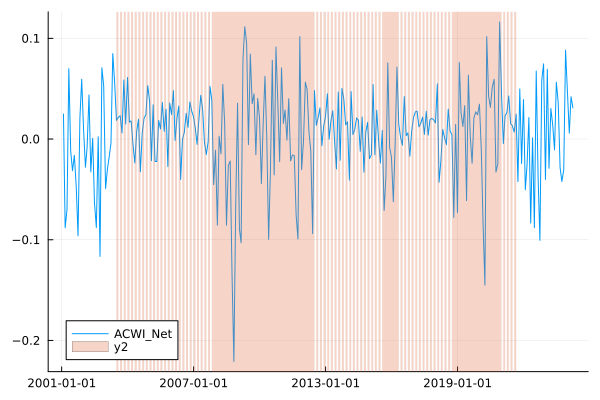

In [100]:
plot(acwi_states[:ACWI_Net ])
vspan!(findwhen(acwi_states[:A] .== 2.0),alpha = 0.3)

In [28]:
sims = [0.06 0.13 -0.23 0.3 -0.05 0.15; 0.15 -0.23 0.06 0.13 0.3 -0.05; -0.05 0.3 -0.23 0.15 0.06 0.13]

function annualise(scenarios:: Matrix, shift=2)
   
    periods = floor.(Int, size(scenarios)[2]/shift)
    result = zeros(size(scenarios)[1],periods)

    for p in 1:periods
        start = (p-1)*shift+1
        en = p*shift
        result[:,p] .= sum(scenarios[:,start:en],dims=2)
    end 
    return result
   
end

annualise(sims,2)


3×3 Matrix{Float64}:
  0.19   0.07  0.1
 -0.08   0.19  0.25
  0.25  -0.08  0.19

In [175]:
function annualise(scenarios:: Vector, shift=2)
   
    periods = floor.(Int, size(scenarios)[1]/shift)
    result = zeros(periods)

    for p in 1:periods
        start = (p-1)*shift+1
        en = p*shift
        result[p] = sum(scenarios[start:en])
    end  
    return result
   
end

annualise(sims[1,:],2)

3-element Vector{Float64}:
 0.19
 0.06999999999999998
 0.09999999999999999

In [37]:
function print_percentiles(X, perc)
    years = size(X)[2]
    simulation_perc = zeros(length(perc),years)

    for t in 1:years
        simulation_perc[:,t] = quantile(X[:,t],perc)
    end
    pretty_table(simulation_perc, backend = Val(:html),header=1:years, row_labels=perc)
end

print_percentiles (generic function with 1 method)

In [177]:
using ScenTrees, SDDP

In [30]:
acwi_pln_98 = identity.(values(from(returns[:ACWI_Net_PLN ],Date(1998,01,01))))
println("mean $(mean(acwi_pln_98)*12)")
println("std $(std(acwi_pln_98)*12^0.5)")

mean 0.06978414756872021
std 0.13188218245803085


In [31]:
println("mean: ",expm1(0.0698))
println("std: ",expm1(0.1319))

mean: 0.07229370106669933
std: 0.14099421414065977


In [38]:
years = 15
n_steps = years 
n_scenarios = 100000
simulations = rand(Normal(0.0723,0.1410),(n_scenarios,n_steps))

print_percentiles(simulations,[0.01, 0.025,0.16,0.5,0.84,0.975, 0.99])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.01,-0.256461,-0.255829,-0.256924,-0.2556,-0.259045,-0.25586,-0.255772,-0.255769,-0.253516,-0.257653,-0.254963,-0.254957,-0.255367,-0.254174,-0.255746
0.025,-0.205118,-0.202794,-0.204864,-0.203936,-0.205414,-0.20513,-0.203714,-0.205563,-0.202683,-0.204026,-0.203735,-0.204327,-0.203779,-0.203221,-0.20524
0.16,-0.0674039,-0.0676064,-0.0674916,-0.0675531,-0.0686685,-0.0681444,-0.0679046,-0.0680489,-0.0661903,-0.0679224,-0.068838,-0.0677261,-0.0691344,-0.0678484,-0.0669795
0.5,0.0724706,0.072844,0.0720711,0.0729988,0.0714322,0.0716921,0.0717148,0.0718211,0.0721964,0.071885,0.0722302,0.0725722,0.071892,0.0730221,0.0726549
0.84,0.212489,0.213328,0.212438,0.212321,0.212129,0.213476,0.21301,0.212553,0.212659,0.212646,0.212569,0.212282,0.211513,0.213343,0.213004
0.975,0.348169,0.351061,0.347241,0.348422,0.348646,0.350653,0.347388,0.348855,0.34737,0.349125,0.348486,0.349543,0.349119,0.350201,0.349858
0.99,0.399952,0.401162,0.398004,0.400375,0.401339,0.403554,0.398028,0.401221,0.399219,0.401771,0.3988,0.399876,0.403369,0.402655,0.400696


In [39]:
quantile((annualise(acwi_pln_98,12)),perc)

MethodError: MethodError: no method matching annualise(::Vector{Float64}, ::Int64)

Closest candidates are:
  annualise(!Matched::Matrix, ::Any)
   @ Main c:\Users\matsz\programowanie\Optymalizacja_portfela\julia_msp\acwi_hmm.ipynb:3


In [40]:
norm_moments = Dict(
    :mean => mean(simulations[:,1]),
    :min => minimum(simulations[:,1]),
    :max => maximum(simulations[:,1]),
    :median => median(simulations[:,1]),
    :std => std(simulations[:,1]),
    :var => var(simulations[:,1]),
    :skew => skewness(simulations[:,1]),
    :kurtosis => kurtosis(simulations[:,1])  
)

Dict{Symbol, Float64} with 8 entries:
  :max      => 0.696258
  :median   => 0.0724706
  :std      => 0.140957
  :mean     => 0.072241
  :var      => 0.0198689
  :kurtosis => 0.0100951
  :skew     => -0.00605008
  :min      => -0.568252

In [183]:
function simulator()
    scenarios = rand(Normal(0.0723,0.1410),180)
    return scenarios #annualise(scenarios,12)
end

graph = SDDP.MarkovianGraph(simulator; budget = fill(5,15), scenarios = 100000);
graph


Root
 (0, 0.0)
Nodes
 (1, -0.08527015785352382)
 (1, 0.06605892455910567)
 (1, 0.16850762296891353)
 (1, 0.304299314320707)
 (1, 0.40381431968177567)
 (2, -0.13820394730194482)
 (2, -0.020973922026791797)
 (2, 0.07319778356766045)
 (2, 0.18286975506440747)
 (2, 0.39080264110361784)
 (3, -0.15218640876204723)
 (3, -0.022386066963818063)
 (3, 0.07329748939817843)
 (3, 0.18224140078397805)
 (3, 0.38719007204374717)
 (4, -0.08918857408856246)
 (4, 0.03810719622804815)
 (4, 0.07737782284177588)
 (4, 0.18341713634058882)
 (4, 0.3924579891481513)
 (5, -0.08645883161411017)
 (5, 0.06228193359831643)
 (5, 0.10898503324858966)
 (5, 0.18590823944682383)
 (5, 0.38751039153335454)
 (6, -0.09410748767013606)
 (6, -0.01771701849691092)
 (6, 0.0732835753048669)
 (6, 0.18292464388222013)
 (6, 0.3900716260998173)
 (7, -0.08586529597447631)
 (7, 0.0639279490644168)
 (7, 0.14514722669374025)
 (7, 0.18629811491641918)
 (7, 0.3880687220602303)
 (8, -0.0851968925169127)
 (8, 0.06599410253777994)
 (8, 0.16588

In [265]:
years = 15
n_steps = years*12
n_scenarios = 5000

hmm = HMM([1.,0],[0.95 0.05; 0.124529 0.875471],[Normal(0.0134,0.0277),Normal(-0.0134,0.0515)])
simulations = zeros(n_scenarios,n_steps)
for s in 1:n_scenarios
    simulations[s,:] .= rand(hmm,n_steps)[2]
end

simulations_ann = annualise(simulations,12)

print_percentiles(simulations_ann,[0.01, 0.025,0.16,0.5,0.84,0.975, 0.99])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.01,-0.30169,-0.387399,-0.383761,-0.404182,-0.406075,-0.426658,-0.401838,-0.399504,-0.411499,-0.409716,-0.396906,-0.396446,-0.395199,-0.368164,-0.417636
0.025,-0.226856,-0.311128,-0.319812,-0.31701,-0.319099,-0.328977,-0.324008,-0.311251,-0.328935,-0.338055,-0.322999,-0.322901,-0.316493,-0.313534,-0.315448
0.16,-0.021264,-0.081918,-0.0983851,-0.0917451,-0.0921757,-0.0910887,-0.10093,-0.096247,-0.0941135,-0.0920878,-0.093863,-0.0835281,-0.0930795,-0.0891107,-0.0846083
0.5,0.123114,0.101786,0.0951179,0.0941449,0.0889066,0.0912375,0.0918015,0.0959657,0.096139,0.0945249,0.0897298,0.0988471,0.0971207,0.0928985,0.0980136
0.84,0.240163,0.225465,0.219408,0.219419,0.219569,0.223775,0.218844,0.219147,0.221041,0.223912,0.217527,0.224058,0.222648,0.221369,0.223598
0.975,0.346619,0.328333,0.326052,0.32632,0.32671,0.334363,0.331742,0.325473,0.323553,0.335171,0.326279,0.328186,0.326604,0.330022,0.329272
0.99,0.384615,0.372057,0.368182,0.356912,0.359337,0.371587,0.37133,0.367641,0.365236,0.374297,0.372779,0.361251,0.374546,0.375842,0.374351


In [68]:
years = 10
n_steps = years*12
n_scenarios = 100000

hmm = HMM([1.,0],transition_matrix(hmm_est_98_PLN),obs_distributions(hmm_est_98_PLN))
simulations = zeros(n_scenarios,n_steps)
for s in 1:n_scenarios
    simulations[s,:] .= rand(hmm,n_steps)[2]
end

simulations_ann = annualise(simulations,12)

print_percentiles(simulations_ann,[0.05, 0.25, 0.5, 0.75, 0.95])

,1,2,3,4,5,6,7,8,9,10
0.05,-0.149625,-0.236768,-0.244632,-0.240539,-0.242089,-0.245085,-0.24263,-0.245398,-0.243373,-0.244619
0.25,0.034168,-0.0138537,-0.0206621,-0.0196271,-0.0199486,-0.0205351,-0.0210083,-0.0208272,-0.0207551,-0.021701
0.5,0.124164,0.098596,0.0948557,0.0943462,0.0944443,0.0948262,0.0945716,0.0948175,0.0943077,0.0943461
0.75,0.201679,0.185667,0.182986,0.183918,0.182613,0.182346,0.183267,0.183709,0.183133,0.183895
0.95,0.305521,0.294477,0.29257,0.295271,0.293621,0.293042,0.295281,0.294042,0.294585,0.293812


In [69]:
t = 5
hmm_moments = Dict(
    :mean => mean(simulations_ann[:,t]),
    :med => median(simulations_ann[:,t]),
    :min => minimum(simulations[:,t]),
    :max => maximum(simulations[:,t]),
    :std => std(simulations_ann[:,t]),
    :var => var(simulations_ann[:,t]),
    :skew => skewness(simulations_ann[:,t]),
    :kurtosis => kurtosis(simulations_ann[:,t])  
)

Dict{Symbol, Float64} with 8 entries:
  :max      => 0.192184
  :std      => 0.162945
  :mean     => 0.0694819
  :var      => 0.0265512
  :med      => 0.0944443
  :kurtosis => 0.768566
  :skew     => -0.779826
  :min      => -0.195949

In [186]:
function regime_sampler_ann()    
    hmm = HMM([1,0.],[0.95 0.05; 0.124529 0.875471],[Normal(0.0134,0.0277),Normal(-0.0134,0.0515)])    
    return annualise(rand(hmm,15*12)[2], 12)
end

regime_sampler_ann()


15-element Vector{Float64}:
  0.09788702939466727
  0.15787577600980918
  0.2078383906331125
 -0.16220031018779318
  0.03905142207514029
 -0.04884145200173236
 -0.04602718777105578
 -0.03778519339876563
  0.049187898474644616
 -0.2592765686296704
 -0.406479248684295
 -0.30528341889505894
  0.13939850726499226
  0.018444918158982998
  0.2673751426746461

In [187]:
graph = SDDP.MarkovianGraph(regime_sampler_ann; budget = fill(3,15), scenarios = 10_000);
graph

Root
 (0, 0.0)
Nodes
 (1, -0.01104916529947708)
 (1, 0.1412265008203048)
 (1, 0.3605825396266169)
 (2, -0.06465236845417043)
 (2, 0.11821037646388369)
 (2, 0.36065853576961016)
 (3, -0.0507792645523982)
 (3, 0.12011386918368262)
 (3, 0.3578894835235927)
 (4, -0.0445726371633153)
 (4, 0.13180512672241596)
 (4, 0.3538950956923958)
 (5, -0.0993064572484079)
 (5, 0.10921362715037496)
 (5, 0.3536837128002545)
 (6, -0.18975536676115737)
 (6, 0.1007377755250875)
 (6, 0.35596097195272014)
 (7, -0.05463733824221738)
 (7, 0.11353951130168959)
 (7, 0.3569025021132474)
 (8, -0.06872563285706823)
 (8, 0.11225556191961773)
 (8, 0.35534232045778014)
 (9, -0.03746035059685476)
 (9, 0.20244694500856966)
 (9, 0.3660907112035794)
 (10, -0.036679037261724265)
 (10, 0.23003401795713072)
 (10, 0.3763858400511046)
 (11, -0.2705820841309571)
 (11, 0.08157253470837597)
 (11, 0.34865802953797936)
 (12, -0.14455601508599325)
 (12, 0.10379230927354642)
 (12, 0.3547760246146654)
 (13, -0.04098939248940385)
 (13, 0

In [264]:
lattice_approximation(fill(4,15),regime_sampler,100000,2,1);

UndefVarError: UndefVarError: `regime_sampler` not defined

In [189]:
Base.LinRange(-3.5,3.5,8)

8-element LinRange{Float64, Int64}:
 -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5

In [223]:
acwi_pln_98 = identity.(values(from(returns[:ACWI_Net_PLN ],Date(1998,01,01))))
println("mean $(mean(acwi_pln_98)*12), std: $(std(acwi_pln_98)*12^0.5)")
hmm_est, loglikehood = train_hmm(acwi_pln_98,2)
hmm_est

mean 0.06978414756872021, std: 0.13188218245803085


Hidden Markov Model with:
 - initialization: [1.0, 4.1981994281931224e-32]
 - transition matrix: [0.9503313581736027 0.04966864182639733; 0.12452259850839971 0.8754774014916002]
 - observation distributions: [Normal{Float64}(μ=0.013408215989160347, σ=0.027652782814984584), Normal{Float64}(μ=-0.013385281661936132, σ=0.05148060200521631)]

In [224]:
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,603.335,0.160899,-0.160623,0.950331,0.124523,0.714861,0.095792,0.178334


In [225]:
init = [1., 0]
trans = [0.95 0.05; 0.12 0.88]
dists = [Normal(0.0134, 0.0277), Normal(-0.0134, 0.0515)]
hmm = HMM(init, trans, dists)

Hidden Markov Model with:
 - initialization: [1.0, 0.0]
 - transition matrix: [0.95 0.05; 0.12 0.88]
 - observation distributions: [Normal{Float64}(μ=0.0134, σ=0.0277), Normal{Float64}(μ=-0.0134, σ=0.0515)]

In [258]:
n_scenarios = 2000
years = 30
n_steps = years * 12

long_obs_seqs = zeros(n_scenarios,n_steps)
for s in 1:n_scenarios
    long_obs_seqs[s,:] .= last(rand(hmm, n_steps))
end
long_obs_seqs = annualise(long_obs_seqs,12)
long_obs_seq_concat = vec(reduce(vcat, transpose(long_obs_seqs)))
seq_ends = cumsum(fill(years,n_scenarios))
println("")

In [259]:
n_points = 6
init_guess = guess_init(n_points)
trans_guess = guess_tmatrix(n_points)
dists_guess = [guess_distribution() for s in 1:n_points]
hmm_guess = HMM(init_guess, trans_guess, dists_guess);

hmm_est_concat, loglikehood = baum_welch(hmm_guess, long_obs_seq_concat; seq_ends);
#regime_summary(loglikehood,hmm_est_concat,1)
hmm_est_concat

MethodError: MethodError: no method matching logpdf(::FullNormal, ::Float64)

Closest candidates are:
  logpdf(!Matched::Soliton, ::Real)
   @ Distributions C:\Users\matsz\.julia\packages\Distributions\UaWBm\src\univariate\discrete\soliton.jl:98
  logpdf(!Matched::Chernoff, ::Real)
   @ Distributions C:\Users\matsz\.julia\packages\Distributions\UaWBm\src\univariate\continuous\chernoff.jl:155
  logpdf(!Matched::DiscreteUniform, ::Real)
   @ Distributions C:\Users\matsz\.julia\packages\Distributions\UaWBm\src\univariate\discrete\discreteuniform.jl:74
  ...


In [260]:
simulations = rand(Normal(0.0723,0.1410),(2000,30)) 
long_obs_seq_concat = vec(reduce(vcat, transpose(simulations)))
seq_ends = cumsum(fill(30,2000))

2000-element Vector{Int64}:
    30
    60
    90
   120
   150
   180
   210
   240
   270
   300
     ⋮
 59760
 59790
 59820
 59850
 59880
 59910
 59940
 59970
 60000

In [262]:
n_points = 8
init_guess = guess_init(n_points)
trans_guess = guess_tmatrix(n_points)
dists_guess = [guess_distribution() for s in 1:n_points]
hmm_guess = HMM(init_guess, trans_guess, dists_guess);

hmm_est_concat, loglikehood = baum_welch(hmm_guess, long_obs_seq_concat; seq_ends);
hmm_est_concat

MethodError: MethodError: no method matching logpdf(::FullNormal, ::Float64)

Closest candidates are:
  logpdf(!Matched::Soliton, ::Real)
   @ Distributions C:\Users\matsz\.julia\packages\Distributions\UaWBm\src\univariate\discrete\soliton.jl:98
  logpdf(!Matched::Chernoff, ::Real)
   @ Distributions C:\Users\matsz\.julia\packages\Distributions\UaWBm\src\univariate\continuous\chernoff.jl:155
  logpdf(!Matched::DiscreteUniform, ::Real)
   @ Distributions C:\Users\matsz\.julia\packages\Distributions\UaWBm\src\univariate\discrete\discreteuniform.jl:74
  ...


In [230]:
using JuMP, HiGHS

In [231]:
norm_moments

Dict{Symbol, Float64} with 8 entries:
  :max      => 0.683246
  :median   => 0.0714269
  :std      => 0.140683
  :mean     => 0.0717612
  :var      => 0.0197916
  :kurtosis => 0.000272329
  :skew     => -0.00728458
  :min      => -0.575091

In [232]:
hmm_moments

Dict{Symbol, Float64} with 8 entries:
  :max      => 0.17347
  :std      => 0.168736
  :mean     => 0.0616567
  :var      => 0.0284719
  :med      => 0.0862558
  :kurtosis => 0.654158
  :skew     => -0.769905
  :min      => -0.159956

In [233]:
moments = norm_moments

Dict{Symbol, Float64} with 8 entries:
  :max      => 0.683246
  :median   => 0.0714269
  :std      => 0.140683
  :mean     => 0.0717612
  :var      => 0.0197916
  :kurtosis => 0.000272329
  :skew     => -0.00728458
  :min      => -0.575091

In [234]:
M = moments[:mean]
V = moments[:var]
S = moments[:skew]
K = moments[:kurtosis]
#X = [-0.252, 0.032, 0.08, 0.244]
n_scenarios = 4
z = 3
X = LinRange(moments[:mean]-z*moments[:std],moments[:mean]+z*moments[:std],n_scenarios) #simulation_perc[:,1] #[simulation_perc[1,1],simulation_perc[2,1],simulation_perc[4,1],simulation_perc[5,1],]


4-element LinRange{Float64, Int64}:
 -0.350287, -0.0689215, 0.212444, 0.493809

In [235]:
model = Model(HiGHS.Optimizer)

@variable(model, Vp >= 0)
@variable(model, Vm >= 0)
@variable(model, Sp >= 0)
@variable(model, Sm >= 0)
@variable(model, Kp >= 0)
@variable(model, Km >= 0)

@variable(model, p[1:n_scenarios] >= 0)
#@variable(model, w[1:3] >= 0.1 )
w = [1 1 1]

@objective(model, Min, w[1]*(Vm+Vp) + w[2]*(Sm+Sp) + w[3]*(Km + Kp))


@constraint(model, dot(X,p) == M)
@constraint(model, sum(p) == 1)

@constraint(model, dot((X .- M).^2, p) + Vm - Vp == V )
@constraint(model, dot((X .- M).^3, p) + Sm - Sp == S )
@constraint(model, dot((X .- M).^4, p) + Km - Kp == K ) 


-Kp + Km + 0.03172838698994398 p[1] + 0.0003917084813573333 p[2] + 0.0003917084813573327 p[3] + 0.03172838698994398 p[4] == 0.0002723286098147426

In [236]:
optimize!(model)

Running HiGHS 1.7.0 (git hash: 50670fd4c): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [4e-04, 1e+00]
  Cost   [1e+00, 1e+00]
  Bound  [0e+00, 0e+00]
  RHS    [3e-04, 1e+00]
Presolving model
5 rows, 10 cols, 26 nonzeros  0s
5 rows, 10 cols, 26 nonzeros  0s
Presolve : Reductions: rows 5(-0); columns 10(-0); elements 26(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 5(0.0668638) 0s
          5     7.4039584848e-03 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 5
Objective value     :  7.4039584848e-03
HiGHS run time      :          0.00


In [237]:
JuMP.termination_status(model)

OPTIMAL::TerminationStatusCode = 1

In [238]:
hcat(X,value.(p))

4×2 Matrix{Float64}:
 -0.350287   -0.0
 -0.0689215   0.5
  0.212444    0.5
  0.493809    0.0

In [239]:
LinRange(-3,3,4)

4-element LinRange{Float64, Int64}:
 -3.0, -1.0, 1.0, 3.0

In [240]:
[0.125, 0.75, 0.125]

3-element Vector{Float64}:
 0.125
 0.75
 0.125

In [241]:
1+ 0.35463

1.35463

In [242]:
sum(value.(p))

1.0

In [243]:
hcat(X,value.(p))

4×2 Matrix{Float64}:
 -0.350287   -0.0
 -0.0689215   0.5
  0.212444    0.5
  0.493809    0.0

In [244]:
dot(value.(p),X)

0.07176122239368289

In [245]:
norm = Normal(0.07,0.132)

Normal{Float64}(μ=0.07, σ=0.132)

In [246]:
pdfs = pdf(norm,[-0.194,0.07,0.334])

3-element Vector{Float64}:
 0.409022473584758
 3.0222900030411566
 0.409022473584758

In [247]:
pdfs/sum(pdfs)

3-element Vector{Float64}:
 0.10650697891920077
 0.7869860421615985
 0.10650697891920077

In [103]:
log(1.025)

0.024692612590371414

In [166]:
t = 1
cpi = log(1.0247)
mu = (0.0698-cpi) * t
sig = 0.1318 * t^0.5
println(mu)
println(sig)

0.045400113176464876
0.1318


In [203]:
zr= LinRange(-2.1,1.5,4)

4-element LinRange{Float64, Int64}:
 -2.1, -0.9, 0.3, 1.5

In [155]:
zr= LinRange(-2.2,1.5,5) # ten wziety do proby

5-element LinRange{Float64, Int64}:
 -2.2, -1.275, -0.35, 0.575, 1.5

In [209]:
pdfs = pdf(Normal(0,1),zr)
r = round.(pdfs/sum(pdfs);digits=5)


4-element Vector{Float64}:
 0.05357
 0.32411
 0.46456
 0.15776

In [212]:
[r .* r[n] for n in 1:4]

4-element Vector{Vector{Float64}}:
 [0.0028697449, 0.0173625727, 0.0248864792, 0.0084512032]
 [0.0173625727, 0.10504729210000001, 0.1505685416, 0.051131593600000004]
 [0.0248864792, 0.1505685416, 0.21581599359999998, 0.0732889856]
 [0.0084512032, 0.051131593600000004, 0.0732889856, 0.024888217600000005]

In [206]:
r = [mu + z * sig for z in zr]

4-element Vector{Float64}:
 -0.23137988682353516
 -0.07321988682353514
  0.08494011317646487
  0.24310011317646485

In [207]:
rd = round.(exp.(r);digits=2) 

4-element Vector{Float64}:
 0.79
 0.93
 1.09
 1.28

In [208]:
rd = round.(expm1.(r);digits=2) 

4-element Vector{Float64}:
 -0.21
 -0.07
  0.09
  0.28

In [149]:
exp(0.025+0.045)

1.0725081812542165

1.0725081812542165

In [253]:
pdfs = cdf(Normal(0,1),-1)


0.15865525393145702

In [254]:
pdfs = cdf(Normal(mu,sig), -0.1938)

0.022750131948179205

In [255]:
pdfs = cdf(LogNormal(mu,sig), 1-0.1762)

0.022738870348463197